## One-dimensional diffusion equation

v1.71, 14 February 2018, by Brian Fiedler 

tweeked 27 September 2023

Demonstrates the numerical solution of the one-dimensional diffusion equation.

The time required for the forecast to run is limited by the deliberate delay in the animation.  So the effectiveness using numpy arrays, rather than lists, is not obvious yet. In future notebooks, numpy arrays will be essential for the forecast to run quickly.  So take special note of the numpy forecast.

In [1]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

Check out the wikipedia: 
[Heat equation in one dimension](http://en.wikipedia.org/wiki/Heat_equation#Derivation_in_one_dimension) 

Let $u(x,t)$ be *temperature* and $q(x,t)$ be *heat flux density*.  You would probably be happier with $T$ as the symbol for temperature, but that's the way it goes...

$$
q = -k \frac{ \partial u}{ \partial x}
$$

$$
\rho c_p \frac{ \partial u}{ \partial t} = - \frac{ \partial q}{ \partial x}
$$

If we let 
$$
F \equiv \frac{q}{\rho c_p}
$$
then $F$ will play the role of a *temperature flux density*. Our coupled PDEs now appear
as:
$$
F = -\frac{k}{\rho c_p} \frac{ \partial u}{ \partial x}
$$

$$
\frac{ \partial u}{ \partial t} = - \frac{ \partial F}{ \partial x}
$$

And we can further tidy up the notation with:

$$
\alpha  \equiv \frac{k}{\rho c_p}
$$

We can combine the coupled first order equations to obtain the familiar one-dimensional diffusion equation:

$$
\frac{ \partial u}{ \partial t} = \alpha \frac{\partial^2 u} {\partial x^2}
$$


<hr>
Re-run the model from here

In [3]:
# make the grid
N = 101 # number of x grid points for u
xmax = 20 # 0 <= x <= xmax
dx = xmax/(N-1.) # grid width
xu = [dx*i for i in range(N)] # grid for u
xF = [.5*dx + dx*i for i in range(N-1)] # grid for F, between u

In [4]:
# initialize u, F and alpha
init = 'gauss'
#init = 'square'
#init = 'sines'
#init = 'twodeltax'
xc = xmax/2. # center of domain
if init == 'gauss':
    ui = [ math.exp( -(x-xc)**2 ) for x in xu ] # Gaussian for initial field of u
elif init == 'square':
    ui = [1 if abs(x-xc)<2.001 else 0 for x in xu] # square wave
elif init == 'sines':
    tp = 2*math.pi/xmax
    ui = [.5+.25*math.sin(tp*x)+.25*math.sin(3*tp*x) for x in xu]
else:
    ui = [.5+.25*math.cos(tp*x)+.25*math.cos(51*tp*x) for x in xu] 
#    print("not implemented")

Fi = [0]*(N-1) # flux is set to zero, will be computed    


(0.0, 1.1)

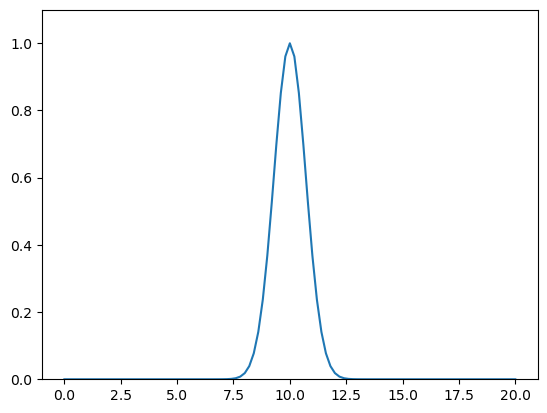

In [5]:
# a quick look at ui
plt.plot(xu,ui)
plt.ylim((0,1.1))

In [6]:
# set physical parameter:
alpha=1. # diffusion coefficient

# set some crunching parameters

# choose one value for crunch:

crunch='py'  # python lists
#crunch='lc' # python list comprehensions
#crunch = 'np' # python numpy arrays

dt = .01 # try dt=.01, .0201, .022, .03
tstop = 4. # stop when t>tstop
dplot = .1 # time increment between plots

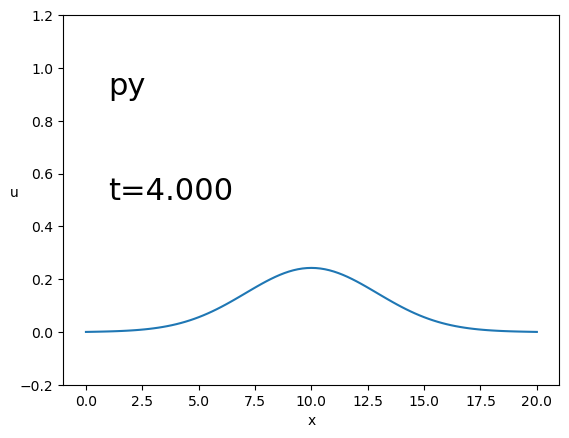

In [7]:
# run the model forward in time
# initialize fields:
if crunch == 'np':
    u = np.array(ui) # a numpy array
    F = np.array(Fi) 
    dudt = np.zeros(N)
else:
    u = ui[:] # this slice copies the entire list
    F = Fi[:] 
    dudt = [0.]*N  # list of N zeros
    
t = 0. # initial value for t    
tplot = 0. # time t for next plot

f, ax = plt.subplots()
display(f)

while t < tstop + dt/2.:
    
    if tplot-dt/2.<t<tplot+dt/2.: #plot
        Time.sleep(1./10.) #Slows down the computation
        ax.clear()
        ax.plot(xu,u)
        ax.text(1,.9,crunch,fontsize=22)
        ax.text(1,.5,'t={0:5.3f}'.format(t),fontsize=22)
        clear_output(wait=True)
        ax.set_xlabel('x')
        ax.set_ylabel('u',rotation=0)
        ax.set_ylim((-.2,1.2))
        display(f)
        tplot = t+dplot
        if t < dt/2.: Time.sleep(2.)
        if t > tstop: break
            
    # step fields forward in time with Euler method.  Nothing fancy!
    if crunch=='py': # use python lists
        for n in range(N-1):
            F[n] = alpha*(u[n] - u[n+1])/dx
        for n in range(N-2):
            dudt[n+1] = (F[n] - F[n+1])/dx
        for i in range(N):
            u[i] = u[i] +dt*dudt[i] 
            
    elif crunch=='lc': # use python lists, with  list comprehensions
        F = [ alpha*(u[n] - u[n+1])/dx for n in range(N-1) ]
        dudt = [0.]+ [ (F[n] - F[n+1])/dx for n in range(N-2) ] + [0.]
        u = [ u[i] + dt* dudt[i] for i in range(N) ]
        
    elif crunch=='np': # use numpy arrays
        F = alpha*( u[:-1] - u[1:] )/dx         
        dudt[1:-1] = ( F[:-1] - F[1:] )/dx
        u = u + dudt*dt 
        
    t = t + dt
    
plt.close() 

In [8]:
beta = 4*alpha*dt/(dx*dx)
print('beta was:', beta )

beta was: 0.9999999999999998


# A theory for the blow up 

With `N=101` and `dt=.03`, the solution eventually erupts into a growing "2-Delta-X-wave".  Clearly this is an error, an artifact of the numerical solution of the PDE. This happens when `dt` is too large. 

Note the  approximation we use:

$$ \frac{\partial^2 u} {\partial x^2}
\approx
\frac{1}{\Delta x} \left( \frac{u_{n+1}-u_n}{\Delta x} - \frac{u_n-u_{n-1}}{\Delta x} \right)
 =
\frac{1}{\Delta x ^2 }\left( u_{n+1}-2 u_n + u_{n-1} \right)
$$

Within even a smooth Gaussian there exists a small amplitude "2-Delta-X-wave".  The  "2-Delta-X-wave" does not need to exist in isolation for the following analysis to be applicable for the instability observed in our numerical solution.
Consider a pure "2-Delta-X-wave", a "saw tooth":

$$
u_n(t) = B(t)(-1)^n
$$

The $(-1)^n$ factor makes $u_{n+1}=-u_n$ and $u_{n-1} = - u_n$.  So:

$$
\frac{d u_n}{d t} = -\frac{4\alpha}{\Delta x^2} u_n 
$$

or

$$
\frac{d B}{dt} = -\frac{4\alpha}{\Delta x^2} B
$$

Writing $B_i=B(t_i)$, our first-order Euler scheme predicts:

$$
\frac{B_{i+1}-B_i}{\Delta t} = - \frac{4\alpha }{\Delta x^2} B_i
$$

$$
B_{i+1} = B_{i}\left( 1- \frac{4\alpha~\Delta t }{\Delta x^2} \right)
$$

Let's define:

$$
\beta \equiv \frac{4\alpha~\Delta t }{\Delta x^2} \qquad r \equiv (1 - \beta)
$$

So the solution for the amplitude of the  "2-Delta-x wave" is

$$
B_{i} = r^i B_{0}
$$


For $\beta>2$ we have $|r|>1$ which causes the "2-Delta-X-wave" to *grow* in amplitude with time.
This is clearly uphysical: a  "2-Delta-X-wave" is supposed to rapidly diffuse away.  The problem is the scheme is trying to
diffuse it way *too* rapidly, causing the decay to overshoot $u_n$ to a value of the opposite sign.

Is this analysis relevant to something other than a 2-Delta-x wave?  Some of you know about [the superposition principle](http://www.acs.psu.edu/drussell/Demos/superposition/superposition.html).  The fundamental principle to remember is that lurking inside of any smoothly varying function in our models is at least some small-amplitude, short-wavelength (high-frequency) component.  In this diffusion calculation, the short-wavelength component is the most difficult to keep stable.

# Student Tasks


## 1.   annotation
Add an annotation to the plots to show $\beta$. Try some experiments with various $\alpha$, $\Delta x$ and $\Delta t$. Does $\beta>2$ provide good guidance about simulations that will "blow up". Complete the following table with 
more experiments.  (I am not sure this table is correct).


| init | &#120572; | $\Delta$ t | $\Delta x$ |$\beta$ | r | Blow up? |
|--- |---| --- | --- | --- | --- |--- |
| gauss | 1| .01 | .2 | 1 | 0 | No |
| gauss | 1| .02 | .2 | 2 | -1 | No|
| gauss | 1| .03 | .2 | 3 | -2 | Yes|
| gauss | 3| .01 | .2 | 3 | -2|  Yes |
| gauss | 3| .0025 ??| .2 ?? | .75 ??| .25 | No |



## 2. crunching alternative
Add another number crunching alternative that uses `numpy` arrays, `crunch='np2'`, which solves for $u$ without the intermediate calculation of $F$:

$$ 
u_n(t+\Delta t) = u_n(t) + \Delta t \frac{\alpha}{\Delta x ^2 }\left( u_{n+1}-2 u_n + u_{n-1} \right)
$$